In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import lsqlin
from scipy import stats
import copy 
from sklearn import svm
from sklearn.isotonic import IsotonicRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
from sklearn import metrics 
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import label_binarize
import tensorflow as tf

In [2]:
vix_df = pd.read_excel( 'VIXfutures_20080414_20201231.xlsx' )

vix_df = vix_df.sort_values( by = ['Date'], ascending = True )

x_df = vix_df[ [ 'Date', 'VIX', 'w', \
                       'CMF30', 'CMF60', 'CMF90', 'CMF120', 'CMF150', \
                       'roll30', 'roll60', 'roll90', 'roll120', 'roll150', \
                       'F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'F9' ] ]

# for eache row, if it contains a non-number element in a column, then drop the entire row
x_df = x_df.dropna()

# for eache row, if it contains a 0 element in a column, then drop the entire row
#x_df = x_df.loc[ ( x_df != 0 ).all( axis = 1 ) ]

# reset the index
x_df= x_df.reset_index( drop = True )

dates = x_df[ 'Date' ]

In [3]:
vix = x_df.VIX 
T = len(vix)

v_1 = x_df.CMF30 
v_2 = x_df.CMF60 
v_3 = x_df.CMF90 
v_4 = x_df.CMF120 
v_5 = x_df.CMF150 

d_theta_log_v_1 = x_df.roll30 
d_theta_log_v_2 = x_df.roll60 
d_theta_log_v_3 = x_df.roll90 
d_theta_log_v_4 = x_df.roll120 
d_theta_log_v_5 = x_df.roll150 

In [4]:
vix_etn_number = 10
x_row = vix_etn_number + 1  #  plus 1 here is for the VIX
x_column = len( v_1 );
X = np.ones( ( x_row, x_column ) )

X[ 0, : ] =  np.log( vix )

X[ 1, : ] =  np.log( v_1 )
X[ 2, : ] =  np.log( v_2 )
X[ 3, : ] =  np.log( v_3 )
X[ 4, : ] =  np.log( v_4 )
X[ 5, : ] =  np.log( v_5 )

X[ 6, : ] = d_theta_log_v_1
X[ 7, : ] = d_theta_log_v_2
X[ 8, : ] = d_theta_log_v_3
X[ 9, : ] = d_theta_log_v_4
X[ 10, : ] = d_theta_log_v_5

In [5]:
#######################################################
####
#### 1-month and 5-month rolling futures portfolios
####
#######################################################

dt = 1/252;
r = .03
vxx = np.zeros(T)
vxz = np.zeros(T)
vxx[0]=100
vxz[0]=100
for t in range(T-1):
    vxx[t+1] = vxx[t]*(1+r*dt + X[ 6, t+1 ]*dt  + (X[ 1, t+1 ]-X[ 1, t ])/X[ 1, t ]  )
    vxz[t+1] = vxz[t]*(1+r*dt + X[ 10, t+1 ]*dt  + (X[ 5, t+1 ]-X[ 5, t ])/X[ 5, t ]  )

r_trade = np.zeros((T-1,5))
r_trade[:,0] = np.ones(T-1)*r*dt
r_trade[:,1] = -np.diff(vxx)/vxx[:-1] + 2*np.diff(vxz)/vxz[:-1]
r_trade[:,2] = -np.diff(vxx)/vxx[:-1] + np.diff(vxz)/vxz[:-1]+r*dt
r_trade[:,3] = np.diff(vxx)/vxx[:-1] - 2*np.diff(vxz)/vxz[:-1]
r_trade[:,4] = np.diff(vxx)/vxx[:-1] - np.diff(vxz)/vxz[:-1]+r*dt

ind_trade = np.zeros((T-1,5)) ### index of max return, to be predicted by classifier
for t in range(T-1):
    ind = np.argmax(r_trade[t,:])
    ind_trade[t,ind] = 1


In [6]:
#######################################################
####
#### divide data into training and testing
####
#######################################################

T_train = int(np.round(T/2))

ind_train = np.arange(0,T_train )
X_train = X[:,ind_train]
y_train = ind_trade[ind_train,:]

ind_test = np.arange(T_train ,T-1)
X_test = X[:,ind_test]
y_test = ind_trade[ind_test,:]

In [7]:
#######################################################
####
#### build and train deep neural network
####
#######################################################


relu_parameter = 0.1
neuron_num = 100
#activation_function = lambda x: tf.keras.activations.tanh( x )  # tanh
#activation_function = lambda x: tf.keras.activations.sigmoid( x )  # Sigmoid
activation_function = lambda x: tf.keras.activations.relu( x, relu_parameter ) # Parameteric rectified linear unit
#activation_function = lambda x: tf.keras.activations.softplus( x )  # SoftPlus

model = tf.keras.Sequential( )
model.add( tf.keras.layers.Flatten( input_shape = ( 11, ) ) )
model.add( tf.keras.layers.Dense( neuron_num, activation = activation_function ) )
model.add( tf.keras.layers.Dense( neuron_num, activation = activation_function ) )
model.add( tf.keras.layers.Dense( neuron_num, activation = activation_function ) )
model.add( tf.keras.layers.Dense( neuron_num, activation = activation_function ) )
model.add( tf.keras.layers.Dense( 5, activation = 'softmax'  ) )

model.compile( loss = 'categorical_crossentropy', optimizer = 'adam',\
              metrics = [ 'accuracy', 'mse' ] )

es = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0.005,\
                                          mode='min', verbose=1,patience = 50)

model_history = model.fit( X_train.T, y_train, \
                  epochs = 100, batch_size = T_train, shuffle = True,\
                          validation_split = .3,verbose = False, callbacks=[es]  )


Epoch 00051: early stopping


/usr/local/Cellar/jupyterlab/1.2.3/libexec/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


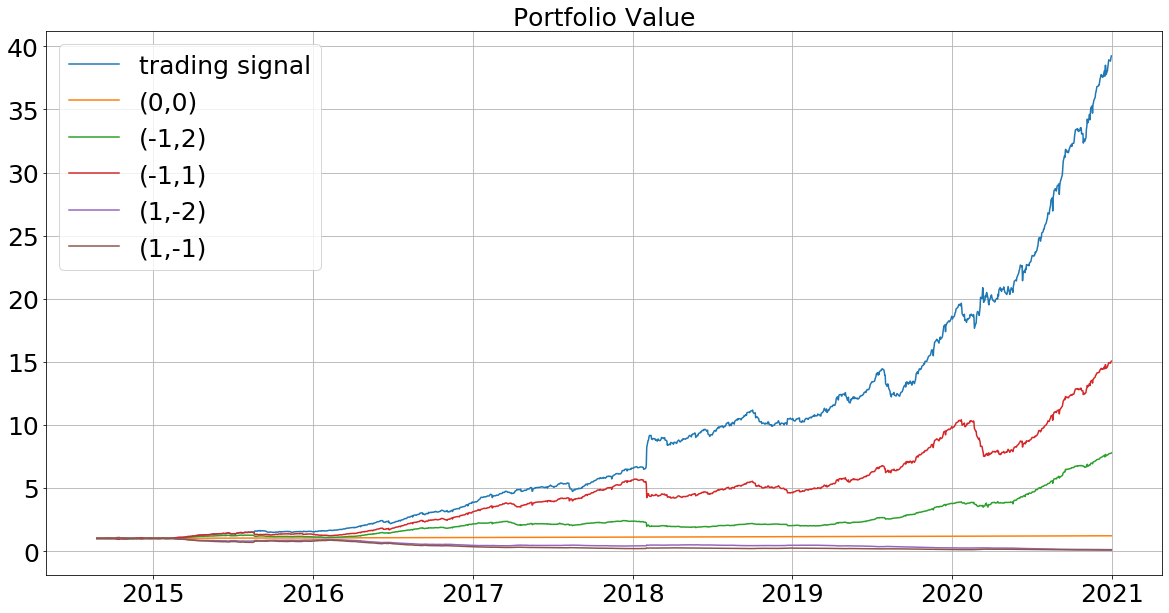

In [8]:
#######################################################
####
#### out-of-sample portfolio using trading signal
####
#######################################################


y_score = model.predict(X_test.T)
my_predict = np.argmax(y_score,axis = 1)


r_my_trade = r_trade[ind_test,my_predict]
p_my_trade = np.exp(np.cumsum(np.log(1+r_my_trade)))
p_trade = np.exp(np.cumsum(np.log(1+r_trade[ind_test,:]),axis=0))


plt.figure( figsize = ( 20, 10 ) )
plt.plot(dates[ind_test],p_my_trade, label="trading signal");
labels = ["(0,0)","(-1,2)","(-1,1)","(1,-2)","(1,-1)"]
for i in range(5):
    plt.plot(dates[ind_test],p_trade[:,i], label=labels[i]);
    
plt.title('Portfolio Value', fontsize = 25 )
plt.xticks( fontsize = 25 );
plt.yticks( fontsize = 25 )
plt.legend(loc="upper left",fontsize = 25)
plt.grid( which = 'major' )
plt.grid( which = 'minor', linestyle = ':' )
plt.savefig( '../VIXmultinomialRegression/NN_multi_Signal100x4x100.eps', format = 'eps', bbox_inches = 'tight' );


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Accuracy Score: 0.45125
my return rate:  0.5780056310621983
position return rates:  [ 0.02999821  0.32308409  0.4270582  -0.34357909 -0.40599425]


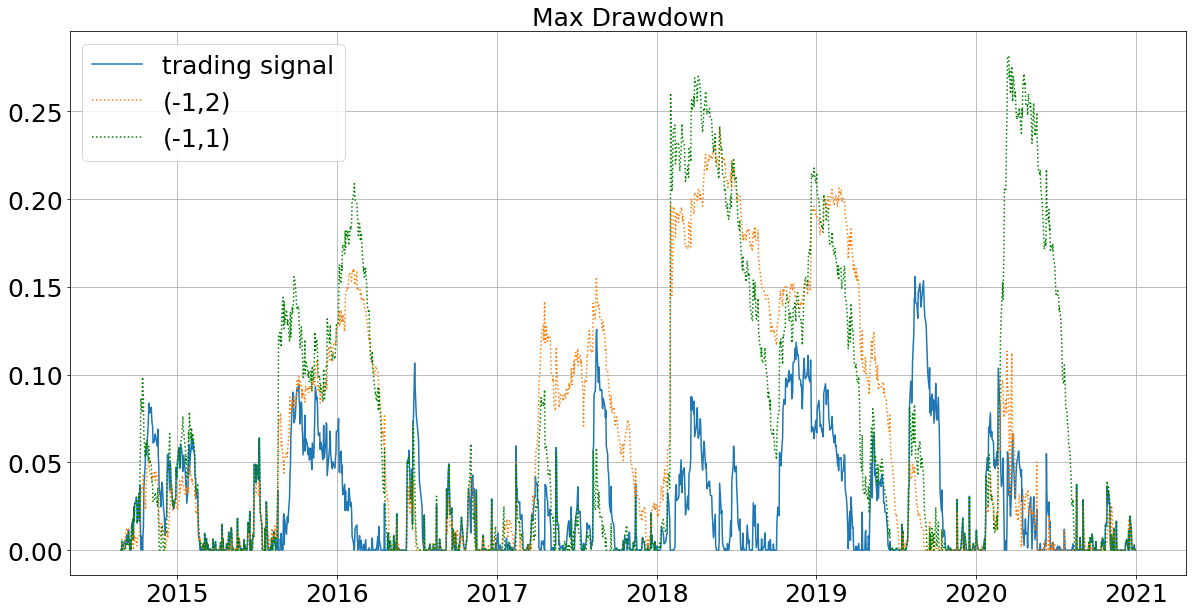

In [9]:
#######################################################
####
#### out-of-sample portfolio return rates and max drawdowns
####
#######################################################

print('Accuracy Score:', metrics.accuracy_score(np.argmax(y_test,axis=1), my_predict)) 
print('my return rate: ',np.log(p_my_trade[-1])/(len(ind_test)*dt))
print('position return rates: ',np.log(p_trade[-1])/(len(ind_test)*dt))

p_my_trade_discount = p_my_trade*np.exp(-r*dt*np.arange(len(ind_test)))
p_trade_discount = np.zeros((len(ind_test),5))
for i in range(5):
    p_trade_discount[:,i] = p_trade[:,i]*np.exp(-r*dt*np.arange(len(ind_test)))
                                        
my_dd = 1-p_my_trade_discount/np.maximum.accumulate(p_my_trade_discount)
dd = 1-p_trade_discount/np.maximum.accumulate(p_trade_discount,axis=0)

plt.figure( figsize = ( 20, 10 ) )
plt.plot(dates[ind_test],my_dd,label="trading signal")
plt.plot(dates[ind_test],dd[:,1],':',label="(-1,2)");
plt.plot(dates[ind_test],dd[:,2],'g:',label="(-1,1)");
plt.title('Max Drawdown', fontsize = 25);
plt.xticks( fontsize = 25 );
plt.yticks( fontsize = 25 )
plt.legend(loc="upper left",fontsize = 25)
plt.grid( which = 'major' )
plt.grid( which = 'minor', linestyle = ':' )
plt.savefig( '../VIXmultinomialRegression/NN_multi_Signal100x4x100_maxDD.eps', format = 'eps', bbox_inches = 'tight' );



In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 11)                0         
_________________________________________________________________
dense (Dense)                (None, 100)               1200      
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 505       
Total params: 32,005
Trainable params: 32,005
Non-trainable params: 0
____________________________________________________

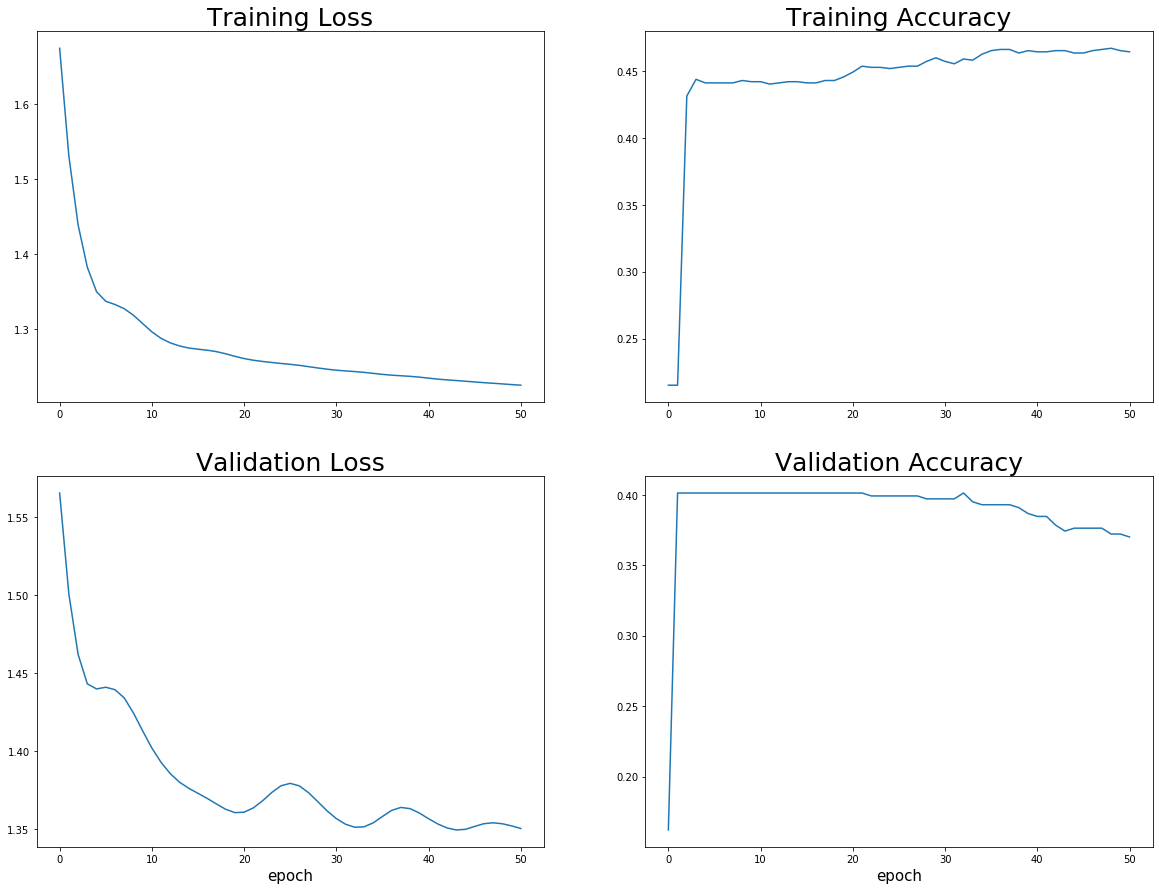

In [11]:
fig, axs = plt.subplots( 2, 2, figsize = ( 20, 15 ) )
axs[0,0].plot(model_history.history['loss'])
axs[0,0].set_title('Training Loss',fontsize = 25);

axs[0,1].plot(model_history.history['accuracy'])
axs[0,1].set_title('Training Accuracy',fontsize = 25);

axs[1,0].plot(model_history.history['val_loss'])
axs[1,0].set_title('Validation Loss',fontsize = 25);
axs[1,0].set_xlabel('epoch',fontsize = 15)

axs[1,1].plot(model_history.history['val_accuracy'])
axs[1,1].set_title('Validation Accuracy',fontsize = 25);
axs[1,1].set_xlabel('epoch',fontsize = 15);

plt.savefig( '../VIXmultinomialRegression/NN_multi_Signal100x4x100_diagnostics.eps', format = 'eps', bbox_inches = 'tight' );

